In [1]:
import pandas as pd
import numpy as np

In [2]:
import torch
import torch.nn as nn

In [3]:
from scipy import stats

In [4]:
import seaborn as sns

In [5]:
import logging
logging.basicConfig(level=logging.INFO)

In [6]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
    
display(dev)

'cuda:0'

In [7]:
# !wget http://api.bitcoincharts.com/v1/csv/coinbaseGBP.csv.gz -O /tmp/coinbaseGBP.csv.gz
# !gzip -d /tmp/coinbaseGBP.csv.gz

-----

In [8]:
NUM_RETURNS = M = 100
TICK_SAMPLE_N = 2000
ROLLING_ZSCORE_WINDOW = 30

In [9]:
# https://stackoverflow.com/a/47165379
def rolling_zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

In [10]:
df = pd.read_csv('/tmp/coinbaseGBP.csv', 
             names=['_dt', 'price', 'size'])

df['dt'] = pd.to_datetime(df['_dt'],unit='s')
df = df.set_index('dt').drop(columns=['_dt'])

df['ret'] = np.log(df.price) - np.log(df.price.shift(1))

df = df.tail(TICK_SAMPLE_N)

display('{} -> {}'.format(df.index[0], df.index[-1]))

rets_z = rolling_zscore(df['ret'], ROLLING_ZSCORE_WINDOW)
rets = np.tanh(rets_z/3)

'2019-01-07 16:12:21 -> 2019-01-07 22:05:22'

/home/uluwatu/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ret', ylabel='Density'>

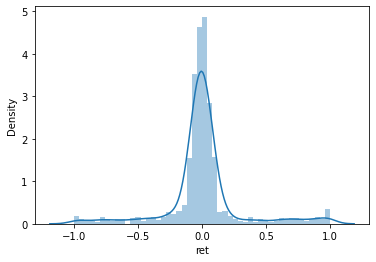

In [11]:
sns.distplot(rets)

In [12]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=3):
        super(LSTM, self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.3
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(dev),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(dev)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )

        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)
        y_pred = self.linear(last_time_step)

        return torch.tanh(y_pred)

In [13]:
def create_sequences(normalised, original, window):
    """
    Returns:
        - rolling `window` size from normalised data 
        - rolling `window` size from original data, shifted to the right by one
    """
    T = len(normalised)
    ret = []
    ret_plus_1 = []
    
    normalised = torch.FloatTensor(normalised)
    original = torch.FloatTensor(original)
    
    for i in range(window, T-window):
        ret.append(normalised[i:i+window])
        ret_plus_1.append(original[i+1:i+window+1])
        
    return ret, ret_plus_1

In [14]:
normalised_rets, original_rets = create_sequences(rets, df['ret'], NUM_RETURNS)
display(len(normalised_rets))
display(len(original_rets))

1800

1800

In [15]:
normalised_rets = torch.cat(normalised_rets) \
    .view(len(normalised_rets) ,-1, 1) \
    .to(dev)

original_rets = torch.cat(original_rets) \
    .view(len(original_rets) ,-1, 1) \
    .to(dev)

In [16]:
model = LSTM(n_features=1, n_hidden=3, seq_len=NUM_RETURNS).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
def returns(Ft, r, delta=0.02):
    T = len(r)
    
    returns = Ft.view(T, -1) * r.view(T, -1)
    
    fees = Ft.view(T, -1)[:,1:] - Ft.view(T, -1)[:,:-1]*delta
    fees = fees.abs()
    fees = torch.cat((torch.zeros(T, 1).to(dev), fees), -1)
    
    realised_returns = returns - fees
    return realised_returns

def neg_sharpe(r):
    sharpe_ratios = r.mean(dim=1) / r.std(dim=1)
    return sharpe_ratios.mean() * -1

def loss(positions, rets):
    realised_returns = returns(positions, rets)
    return neg_sharpe(realised_returns)

In [18]:
epochs = 1600
loss_history = []

for i in range(epochs):
    
    model.reset_hidden_state()
    
    y_pred = model(normalised_rets)
    
    _loss = loss(y_pred, original_rets)
    loss_history.append(_loss.item())
    
    if i % 100 == 0:
        logging.info(_loss)
    
    optimizer.zero_grad()
    _loss.backward()
    optimizer.step()

INFO:root:tensor(7.1846, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.8699, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.6775, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.6891, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.6699, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.6678, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.6619, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.5214, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2822, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2739, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2786, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2917, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2966, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2689, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:tensor(0.2700, device='cuda:0', grad_fn=<MulBackward0>)
INFO:root:

/home/uluwatu/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

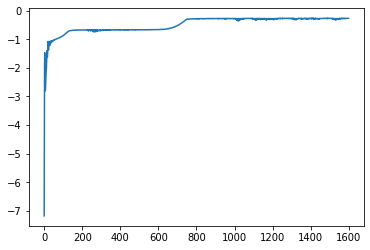

In [19]:
sns.lineplot(range(0, len(loss_history)), np.array(loss_history)*-1)